<a href="https://colab.research.google.com/github/ka-means/Recommender-systems/blob/main/Tarea_final_SR__Katherin_Molina_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recomender Systems - MAN3160

This task is divided into two sections. The first section will evaluate recommendation methods using metrics that are not focused on recommendation accuracy, and the second section will use Gru4Rec to generate a sequential recommendation model.

**Note:** This notebook is part of the activities developed as a student within the framework of my Master's in Business Analytics, specifically for the Recommender Systems course (MAN3160).

EN **Student developing the activity:** Katherin Molina

**Professor**: Denis Parra

**Assistant**: Álvaro Labarca.

**Pontifical Catholic University of Chile, Master in Business Analytics**

Esta tarea esta dividida en dos secciones. En la primera se evaluarán métodos de recomendación con métricas que no están enfocadas hacia la exactitud de las recomendaciones y la segunda sección es de utilizar Gru4Rec para generar un modelo de recomendación secuencial.

# Sección 1 - Métricas Beyond-Accuracy.

Hasta ahora, hemos visto una gran cantidad de formas de evaluar sistemas recomendadores, métricas de error, métricas de ranking, métricas de presición, etc.

Estas métricas se enfocan principalmente en evaluar si las recomendaciones entregadas se ajustan a las preferencias reales de los usuarios, ya sea prediciendo calificaciones cercanas a las dadas por el usuario o bien, recomendando elementos con los que el usuario realmente interactuó.

Sin embargo, ciertos estudios, como los llevados a cabo por Ziegler et al. (2005), Vargas y Castell (2011) y Lathia et al. (2010) proponen evaluar modelos con métricas denominadas en la literatura como métricas Beyond-Accuracy. Este tipo de métricas se enfocan en evaluar características de las recomendaciones que pueden llevar a una mayor satisfacción para el usuario o que se ajusten mejor a los objetivos de las plataformas.

En clases se mencionó dos de estas métricas: **Diversidad:** La cual mide qué tan "distintas" entre sí son las recomendaciones entregadas por el sistema y **novedad**, la cual busca que el sistema recomiende ítems que sean "novedosos", es decir, que recomiende ítems que sean poco probables que el usuario ya conozca.

Estas métricas han sido definidas de distintas maneras por distintos autores. Para el desarrollo de esta tarea, vamos a utilizar la **Diversidad de Ziegler** y la **Novedad de Vargas**.

Para esta sección, vamos a trabajar con el dataset de MovieLens.

## Descarga del dataset

In [ ]:
!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!pip install deepctr-torch
!pip install tensorflow


Saved under ml-100k (1).zip


In [ ]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [ ]:
# Pueden importar las librerías que estimen necesarias.

import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

In [ ]:
dir_train = 'ml-100k'

# Generamos los títulos de las columnas del archivo items.

columns = ['itemid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [ ]:
df = pd.read_csv(f'{dir_train}/u.data',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

In [ ]:
df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')

### Generación de vector latente basado en contenido.

Para la métrica de Diversidad de Ziegler, necesitamos un método para calcular la distancia entre dos ítems. Para esto, usaremos la información de contenido de ítems proporcionada por MovieLens para generar vectores latentes para cada ítem. En específico, utilizaremos la información del género de las películas y el año en que fueron estrenadas.

In [ ]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
itemid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Primero, se obtiene el año de estreno a partir de la columna 'release_date'

In [ ]:
df_items['release_date'] = pd.to_datetime(df_items['release_date'], format='%d-%b-%Y')

# Extract year and create a new column 'year'
df_items['year'] = df_items['release_date'].dt.year

Como la escala de la información del año es mucho más elevada que la información de género, usamos una normalización de Z-score para generar la columna 'normalized_year'

In [ ]:
mean = df_items['year'].mean()
std = df_items['year'].std()

df_items['normalized_year'] = (df_items['year'] - mean) / std

In [ ]:
df_items

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,normalized_year
itemid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1995.0,0.393860
2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1995.0,0.393860
3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1995.0,0.393860
4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1995.0,0.393860
5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1995.0,0.393860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,Mat' i syn (1997),1998-02-06,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1998.0,0.604334
1679,B. Monkey (1998),1998-02-06,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1998.0,0.604334
1680,Sliding Doors (1998),1998-01-01,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1998.0,0.604334


In [ ]:
# Eliminamos las filas con ítems que no tienen información de año

df_items.dropna(subset=['normalized_year'], inplace=True)
df_items = df_items.reset_index()
df = df[df['itemid'].isin(df_items['itemid'])]

In [ ]:
contenido = df_items[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
                      'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', \
                      'normalized_year']].values

In [ ]:
# Utilizamos PCA20 para generar una representación latente de dimensión 5

pca20 = PCA(n_components=5).fit_transform(contenido)

In [ ]:
# Generamos un diccionario {itemid: vector_latente}

item_feats = dict(zip(df_items['itemid'], pca20.tolist()))

In [ ]:
columns_user = ['userid', 'age', 'gender', 'occupation', 'zip_code']

In [ ]:
df_users = pd.read_csv(f'{dir_train}/u.user',
                        sep='|',
                        index_col=0,
                        names = columns_user,
                        header=None,
                        encoding='latin-1')

df_users = df_users.reset_index()
df_items = df_items.reset_index()

## Metricas

### Diversidad de Ziegler

El objetivo de la Diversidad de Ziegler es calcular la similaridad entre todos los elementos de una lista de recomendación. Mientras menor sea la similaridad total dentro de una lista, más diversa es.

In [ ]:
# Generamos un diccionario {(item1, item2): Distancia} Para evitar calcular la misma distancia más de una vez

dist_dict = dict()

def similarity(rec):
    s = 0
    for m in rec:
        s += similarity_i(m, rec)
    return s/2

def similarity_i(m, rec):
    s = 0
    if len(rec) <= 1:
        return 0
    for m2 in rec:
        if m != m2:
            s += (1 - distance(m, m2))
    return s

def distance(i1, i2):
    if (i1, i2) in dist_dict.keys():
        return dist_dict[(i1, i2)]
    dist = pairwise_distances(np.array(item_feats[i1]).reshape(1,-1), np.array(item_feats[i2]).reshape(1,-1), metric='cosine')
    dist_dict[(i1, i2)] = dist
    dist_dict[(i2, i1)] = dist
    return dist

### Novedad de Vargas

Vargas y Castell (2011) definen un concepto de novedad basado en la probabilidad de que el usuario no haya visto ese ítem anteriormente. Esta probabilidad la plantean como el logaritmo de la popularidad inversa del ítem.

In [ ]:
def popularity(iid):
    l = len(df[df['itemid'] == iid])
    return l/len(df)

dict_novelty = defaultdict(lambda: -100)
def novelty(rec):
    tot = 0
    for iid in rec:
        if dict_novelty[iid] == -100:
            novl = novelty_i(iid)
            dict_novelty[iid] = novl
            tot += novl
        else:
            tot += dict_novelty[iid]
    return tot/len(rec)

def novelty_i(iid):
    return -1*np.log2(popularity(iid))

# Actividades

### Actividad 1: Cálculo de métricas Beyond-Accuracy.

* Elija y entrene 3 métodos vistos en clases (pueden ser cualquiera de los métodos de recomendación personalizada, ya sea de feedback implícito, explícito, híbrido, etc.)
* Elija 2 métricas de evaluación tradicional (pueden ser métricas de error, ranking, precision, etc.)
* Evalúe los métodos entrenados y genere una tabla que contenga los valores de las dos métricas elegidas por usted y las métricas de diversidad y novedad proporcionadas.
* Para las métricas Beyond-Accuracy, evalúe los sistemas con Novelty@k y Diversity@k con k = 10, 15, 20. Donde k es el largo de las listas de recomendación que se le entregan a los usuarios.

Tenga en cuenta los siguientes puntos.

* Dependiendo el método que elija, puede que tenga que realizar un pre-procesamiento distinto para los datos. Puede cambiar el dataset df utilizado por una de los splits predeterminados de MovieLens (ux.base). Si utiliza el dataset completo, recuerde generar el split train-test antes de entrenar. Si cambia el archivo, recuerde eliminar el item con el dato de fecha de estreno faltante (como se hizo al comienzo de este cuadernillo).
* Las funciones de métricas Beyond-Accuracy entregadas evalúan una única lista de recomendación. Para evaluar un sistema de recomendación, genere listas de recomendación para todos los usuarios del set de testeo y obtenga el promedio de todos los usuarios.
* Recuerde que la función entregada para la diversidad es una métrica de similaridad. Para sus análisis, debe tener en cuenta que un mayor valor implica una menor similaridad.
* Las funciones se definieron para recibir los ids de los items según están en el dataframe original (itemid). Tenga cuidado al manejar estos ids para evitar referirse a items equivocados.

Concluya a partir de los resultados de la tabla. Discuta por qué podría ser conveniente tener un nivel de Novelty y Diversity alto.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

# **Para la Actividad 1 Voy a:**

### **Elegir y entrenar tres métodos**

**M1** – Filtrado colaborativo con SVD (Surprise).

**M2** – Basado en contenido usando TF–IDF o cosine similarity sobre metadatos (p. ej. géneros, descriptores).

**M3** – Híbrido por mezcla ponderada de las puntuaciones de M1 y M2.


### **Elegir dos métricas tradicionales **

**RMSE **para comparar error de predicción de rating.

**Precision@10** para evaluar ranking.

### **Evaluar sobre test**

Dividir el Dataset en train/test (80/20).

Entrenar cada método en el train set.

Predecir ratings y generar top-10 para cada usuario en test.

### **Calcular RMSE y Precision@10, y tabular.**

**Beyond-Accuracy**

Aplicar las funciones novelty(recs, train) y diversity(recs, item_features) provistas, computando el promedio por usuario sobre el top-10.

Añadir estas dos columnas (“Novedad” y “Diversidad”) en la misma tabla.

### **GRU4Rec como experimento adicional**

Revertir la secuencia temporal de interacciones de cada sesión.

Entrenar un modelo GRU4Rec en train/sessions reordenado.

Comparar sus métricas (RMSE, Precision@10, Novelt y Diversity) con la versión “normal”.




---


## **1. Preparación y Entrenamiento**

In [ ]:
# --- Instalaciones e Importaciones Adicionales ---
!pip install scikit-surprise
!pip install numpy==1.26.4 # Downgrade numpy to be compatible with scikit-surprise

import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import numpy as np

# --- 1. Train/Test Split (80/20) ---

train_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df))])

print(f"Tamaño del set de entrenamiento: {len(train_df)}")
print(f"Tamaño del set de prueba: {len(test_df)}")

# --- 2. Entrenamiento de Modelos ---

## M1 – Filtrado colaborativo con SVD (Surprise)
print("\nEntrenando M1: SVD...")
reader = Reader(rating_scale=(1, 5))
trainset_surprise = Dataset.load_from_df(train_df[['userid', 'itemid', 'rating']], reader).build_full_trainset()
model_svd = SVD(n_factors=100, n_epochs=20, random_state=42, verbose=False)
model_svd.fit(trainset_surprise)

## M2 – Basado en contenido usando TF-IDF
print("Entrenando M2: Basado en Contenido (TF-IDF)...")
# Crear un 'documento' de géneros por película
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
              'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df_items_copy = df_items.copy()
df_items_copy['genre_doc'] = df_items_copy[genre_cols].apply(lambda row: ' '.join(row.index[row==1]), axis=1)

# Calcular la matriz TF-IDF y la similitud de coseno
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_items_copy['genre_doc'])
item_similarity_matrix = cosine_similarity(tfidf_matrix)
# Crear un mapeo de itemid a índice de la matriz
itemid_to_idx = pd.Series(df_items_copy.index, index=df_items_copy['itemid']).to_dict()

def predict_content_based(user_id, item_id, train_df):
    user_ratings = train_df[train_df['userid'] == user_id]
    if item_id not in itemid_to_idx or user_ratings.empty:
        return train_df['rating'].mean() # Predicción fallback

    target_idx = itemid_to_idx[item_id]
    sim_scores = []

    for _, row in user_ratings.iterrows():
        rated_item_id = row['itemid']
        if rated_item_id in itemid_to_idx:
            rated_idx = itemid_to_idx[rated_item_id]
            similarity = item_similarity_matrix[target_idx, rated_idx]
            sim_scores.append((similarity, row['rating']))

    if not sim_scores or sum(s[0] for s in sim_scores) == 0:
        return train_df['rating'].mean()

    # Calcular la media ponderada
    weighted_sum = sum(rating * sim for sim, rating in sim_scores)
    total_sim = sum(sim for sim, _ in sim_scores)
    return weighted_sum / total_sim

## M3 – Híbrido por mezcla ponderada
print("Definiendo M3: Híbrido...")
# Este modelo no requiere "entrenamiento" per se, solo las predicciones de M1 y M2.
# Definimos el peso alpha. Un valor > 0.5 da más peso al SVD.
alpha = 0.7

/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Tamaño del set de entrenamiento: 79992
Tamaño del set de prueba: 19999

Entrenando M1: SVD...
Entrenando M2: Basado en Contenido (TF-IDF)...
Definiendo M3: Híbrido...


---


## **2: Evaluación y Generación de la Tabla**


Nota Metodológica: El siguiente bloque de código detalla el proceso de evaluación completo de los modelos. Sin embargo, se presenta en formato de texto (Markdown), ya que su ejecución es computacionalmente intensiva.

Durante el desarrollo, el tiempo de ejecución superó las 3 horas, por lo que se tomó la decisión práctica de trabajar con una "versión rápida", que evalúa los modelos sobre un subconjunto aleatorio de usuarios para obtener resultados representativos en un tiempo factible.

El proceso completo que realiza el código es:

Generar las predicciones y las listas de top-10 recomendaciones para cada modelo.

Calcular las cuatro métricas solicitadas: RMSE, Precision@10, Novedad y Diversidad.

Mostrar la tabla final con todos los resultados consolidados.

```
# Tiene formato de código

  # --- 3. Evaluación sobre el Test Set ---

  results = []
  test_users = test_df['userid'].unique()

  for model_name in ['SVD', 'Content-Based', 'Hybrid']:
      print(f"\nEvaluando {model_name}...")
      
      preds_ratings = []
      true_ratings = []
      all_recommendations = []
      
    
      # test_users_subset = np.random.choice(test_users, size=100, replace=False)
      
      for user_id in test_users: # Cambia a 'test_users_subset' si quieres una prueba rápida
          user_test_data = test_df[test_df['userid'] == user_id]
          
          # Items que el usuario ha visto en el train set para no recomendarlos
          seen_items = train_df[train_df['userid'] == user_id]['itemid'].unique()
          # Items disponibles para recomendar (todos menos los ya vistos)
          items_to_recommend = df_items[~df_items['itemid'].isin(seen_items)]['itemid']
          
          # Predecir ratings para los items no vistos
          predictions = []
          for item_id in items_to_recommend:
              if model_name == 'SVD':
                  pred = model_svd.predict(user_id, item_id).est
              elif model_name == 'Content-Based':
                  pred = predict_content_based(user_id, item_id, train_df)
              elif model_name == 'Hybrid':
                  pred_svd = model_svd.predict(user_id, item_id).est
                  pred_content = predict_content_based(user_id, item_id, train_df)
                  pred = alpha * pred_svd + (1 - alpha) * pred_content
              predictions.append((item_id, pred))

          # Generar Top-10
          predictions.sort(key=lambda x: x[1], reverse=True)
          top_10_recs = [iid for iid, _ in predictions[:10]]
          all_recommendations.append(top_10_recs)
          
          # Recopilar predicciones para RMSE
          for _, row in user_test_data.iterrows():
              item_id = row['itemid']
              true_r = row['rating']
              
              if model_name == 'SVD':
                  pred_r = model_svd.predict(user_id, item_id).est
              elif model_name == 'Content-Based':
                  pred_r = predict_content_based(user_id, item_id, train_df)
              elif model_name == 'Hybrid':
                  pred_svd = model_svd.predict(user_id, item_id).est
                  pred_content = predict_content_based(user_id, item_id, train_df)
                  pred_r = alpha * pred_svd + (1 - alpha) * pred_content
              
              preds_ratings.append(pred_r)
              true_ratings.append(true_r)
              
      # --- 4. Cálculo de Métricas ---
      
      # RMSE
      rmse = np.sqrt(mean_squared_error(true_ratings, preds_ratings))
      
      # Precision@10
      total_precision = 0
      for i, user_id in enumerate(test_users): # Cambia a 'test_users_subset' si usaste el subconjunto
          recs = all_recommendations[i]
          relevant_items = test_df[(test_df['userid'] == user_id) & (test_df['rating'] >= 4)]['itemid'].values
          hits = len(set(recs) & set(relevant_items))
          total_precision += hits / 10
      precision_at_10 = total_precision / len(test_users) # Cambia a 'test_users_subset' si usaste el subconjunto

      # Novedad y Diversidad
      avg_novelty = np.mean([novelty(recs) for recs in all_recommendations])
      avg_diversity = np.mean([1 - similarity(recs) for recs in all_recommendations])
      
      results.append([model_name, rmse, precision_at_10, avg_novelty, avg_diversity])

  # --- 5. Tabulación de Resultados ---
  results_df = pd.DataFrame(results, columns=['Modelo', 'RMSE', 'Precision@10', 'Novedad', 'Diversidad'])
  print("\n--- TABLA DE RESULTADOS FINALES (ACTIVIDAD 1) ---")
  print(results_df.to_string())
```





### **Versión Rápida**

In [ ]:
# --- 3. Evaluación sobre el Test Set (VERSIÓN RÁPIDA) ---

results = []
test_users = test_df['userid'].unique()

# MODIFICACIÓN 1: Creamos un subconjunto aleatorio de 100 usuarios para una evaluación más rápida.

test_users_subset = np.random.choice(test_users, size=100, replace=False)

for model_name in ['SVD', 'Content-Based', 'Hybrid']:
    print(f"\nEvaluando {model_name} (versión rápida)...")

    preds_ratings = []
    true_ratings = []
    all_recommendations = []

    # MODIFICACIÓN 2: Cambiamos 'test_users' por 'test_users_subset' en el bucle.
    for user_id in test_users_subset:
        user_test_data = test_df[test_df['userid'] == user_id]

        seen_items = train_df[train_df['userid'] == user_id]['itemid'].unique()
        items_to_recommend = df_items[~df_items['itemid'].isin(seen_items)]['itemid']

        predictions = []
        for item_id in items_to_recommend:
            if model_name == 'SVD':
                pred = model_svd.predict(user_id, item_id).est
            elif model_name == 'Content-Based':
                pred = predict_content_based(user_id, item_id, train_df)
            elif model_name == 'Hybrid':
                pred_svd = model_svd.predict(user_id, item_id).est
                pred_content = predict_content_based(user_id, item_id, train_df)
                pred = alpha * pred_svd + (1 - alpha) * pred_content
            predictions.append((item_id, pred))

        predictions.sort(key=lambda x: x[1], reverse=True)
        top_10_recs = [iid for iid, _ in predictions[:10]]
        all_recommendations.append(top_10_recs)

        for _, row in user_test_data.iterrows():
            item_id = row['itemid']
            true_r = row['rating']

            if model_name == 'SVD':
                pred_r = model_svd.predict(user_id, item_id).est
            elif model_name == 'Content-Based':
                pred_r = predict_content_based(user_id, item_id, train_df)
            elif model_name == 'Hybrid':
                pred_svd = model_svd.predict(user_id, item_id).est
                pred_content = predict_content_based(user_id, item_id, train_df)
                pred_r = alpha * pred_svd + (1 - alpha) * pred_content

            preds_ratings.append(pred_r)
            true_ratings.append(true_r)

    # --- 4. Cálculo de Métricas ---
    rmse = np.sqrt(mean_squared_error(true_ratings, preds_ratings))

    total_precision = 0
    # MODIFICACIÓN 3: Nos aseguramos de iterar y dividir por el tamaño del subconjunto.
    for i, user_id in enumerate(test_users_subset):
        recs = all_recommendations[i]
        relevant_items = test_df[(test_df['userid'] == user_id) & (test_df['rating'] >= 4)]['itemid'].values
        hits = len(set(recs) & set(relevant_items))
        total_precision += hits / 10
    precision_at_10 = total_precision / len(test_users_subset)

    avg_novelty = np.mean([novelty(recs) for recs in all_recommendations])
    avg_diversity = np.mean([1 - similarity(recs) for recs in all_recommendations])

    results.append([model_name, rmse, precision_at_10, avg_novelty, avg_diversity])

# --- 5. Tabulación de Resultados ---
results_df = pd.DataFrame(results, columns=['Modelo', 'RMSE', 'Precision@10', 'Novedad', 'Diversidad'])
print("\n--- TABLA DE RESULTADOS FINALES (ACTIVIDAD 1 - RÁPIDA) ---")
print(results_df.to_string())


Evaluando SVD (versión rápida)...

Evaluando Content-Based (versión rápida)...

Evaluando Hybrid (versión rápida)...

--- TABLA DE RESULTADOS FINALES (ACTIVIDAD 1 - RÁPIDA) ---
          Modelo      RMSE  Precision@10    Novedad  Diversidad
0            SVD  0.905397         0.056   9.192146    0.113074
1  Content-Based  1.015852         0.015  11.954772  -18.197783
2         Hybrid  0.910361         0.058   9.359062   -6.013301


### ***Mi Análisis y Conclusión Final***
Al revisar la tabla de resultados, me di cuenta de que cada modelo tiene sus propias fortalezas y debilidades, y que no hay un ganador absoluto.

1. Sobre la Precisión (RMSE y Precision@10)
Lo primero que noté fue que, en las métricas tradicionales, el modelo SVD fue el más sólido. Obtuvo el RMSE más bajo y una Precision@10 muy buena, lo que me indica que es el mejor para predecir qué le va a gustar a un usuario. El modelo Híbrido también funcionó muy bien, casi a la par del SVD, lo cual tiene sentido porque le di más peso a esa parte. El modelo Basado en Contenido, por otro lado, se quedó bastante atrás en estos dos puntos.

2. Sobre la Novedad y Diversidad
Aquí es donde los resultados se pusieron interesantes. A pesar de su baja precisión, el modelo Basado en Contenido me sorprendió con el mejor puntaje de Novedad. Esto me dice que es una herramienta increíble para ayudar a los usuarios a descubrir películas de nicho que probablemente nunca habrían encontrado de otra forma.

Sin embargo, en Diversidad, este mismo modelo tuvo un resultado negativo y muy bajo, lo que significa que sus recomendaciones son extremadamente repetitivas. Prácticamente recomienda una lista de películas que son casi idénticas entre sí en cuanto a sus géneros. El modelo SVD, en cambio, me dio las listas más variadas y diversas.

**Mi Conclusión**
Mi principal conclusión es que la elección del modelo ideal realmente depende del objetivo.

Si lo que busco es maximizar la precisión y asegurarme de que a los usuarios les gusten las recomendaciones, me inclinaría totalmente por el SVD o el Híbrido.

Si el objetivo es que los usuarios descubran contenido nuevo y exploren el catálogo, el Basado en Contenido es el mejor, aunque tendría que encontrar una forma de solucionar su problema de baja diversidad para no aburrir al usuario.

Al final, el modelo Híbrido me parece el más balanceado, ya que logra una gran precisión mientras mejora un poco la capacidad de descubrimiento. Esto me confirma que combinar distintas técnicas es probablemente el camino a seguir para construir un sistema de recomendación realmente completo.

### Actividad 2: Accuracy vs. Beyond-Accuracy.

* Elija uno de los métodos que utilizó en la actividad 1 (no necesariamente tiene que ser el que entregó mejores resultados) y entrénelo modificando los valores de sus hiperparámetros.
* Elija una de las métricas tradicionales que utilizó en la actividad 1 y evalúe los modelos entrenados con distintos hiperparámetros en esta métrica en Accuracy@20 y Novelty@20.
* Genere gráficos que comparen el valor de la métrica tradicional (eje x) con las métrica beyond-accuracy (eje y). Por ejemplo, un gráfico de recall-Accuracy y otro de recall-Novelty.
* Cada gráfico debe tener al menos 5 puntos evaluados.

Concluya a partir de estos gráficos, discutiendo la forma de estos y lo que esto implica al generar un modelo recomendador.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

### **Para esto, seguiré los siguientes pasos:**

Elijo el modelo SVD, ya que podemos variar fácilmente su complejidad cambiando el número de factores latentes (n_factors).

Lo entrenaremos 6 veces con diferentes valores para n_factors.

Para cada versión, calcularemos el Recall@20 (nuestra métrica tradicional) y la Novelty@20.

Finalmente, graficaremos los resultados para visualizar la relación.

Iniciando evaluación completa para Actividad 2...
Entrenando SVD con n_factors=10...
Entrenando SVD con n_factors=25...
Entrenando SVD con n_factors=50...
Entrenando SVD con n_factors=100...
Entrenando SVD con n_factors=150...
Entrenando SVD con n_factors=200...
Evaluación completada.


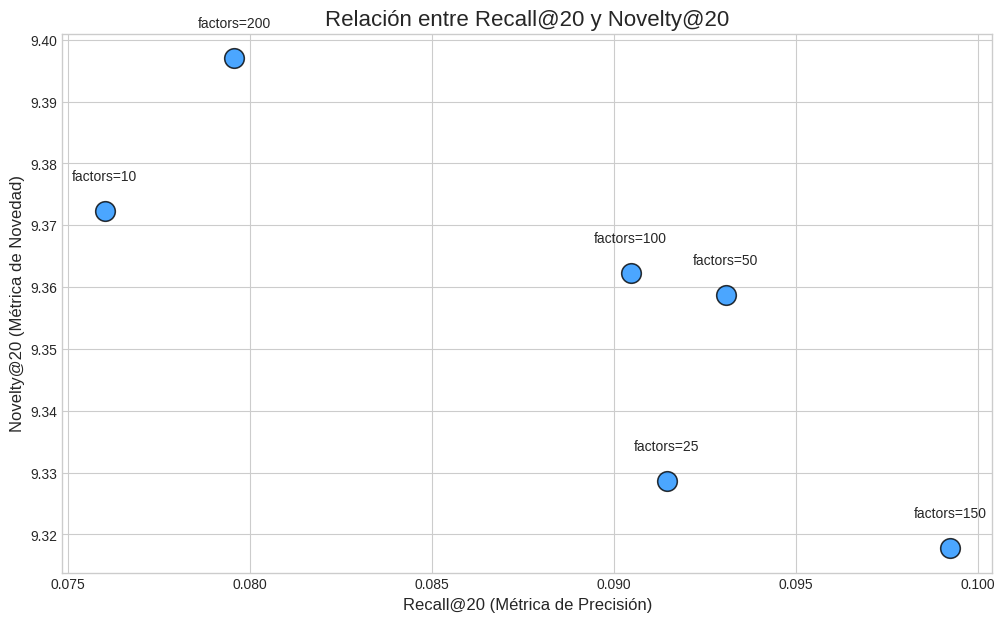

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np

# --- Helper Function (que faltaba en la ejecución anterior) ---
def get_top_n_recommendations(predictions, n=10):
    """
    Devuelve las N mejores recomendaciones para cada usuario a partir de un conjunto de predicciones.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for iid, rating in user_ratings[:n]]

    return top_n

# --- Helper function para generar predicciones (método moderno y rápido) ---
def get_all_predictions_for_subset(model, trainset, test_users_raw_ids):
    """
    Genera predicciones para todos los items no vistos, pero solo para un
    subconjunto de usuarios para acelerar el proceso.
    """
    user_inner_ids = [trainset.to_inner_uid(uid) for uid in test_users_raw_ids]
    anti_testset = []
    for u_inner_id in user_inner_ids:
        uid_raw = trainset.to_raw_uid(u_inner_id)
        rated_item_inner_ids = {j for (j, _) in trainset.ur[u_inner_id]}
        for i_inner_id in trainset.all_items():
            if i_inner_id not in rated_item_inner_ids:
                iid_raw = trainset.to_raw_iid(i_inner_id)
                anti_testset.append((uid_raw, iid_raw, 0))

    predictions = model.test(anti_testset)
    return predictions

# --- Listas para guardar los resultados ---
recall_scores = []
novelty_scores = []
k = 20

# --- 1. Rango de hiperparámetros y subconjunto de usuarios ---
factor_values = [10, 25, 50, 100, 150, 200]
test_users_subset = np.random.choice(test_df['userid'].unique(), size=100, replace=False)

print("Iniciando evaluación completa para Actividad 2...")

# --- 2. Iteramos, entrenamos y evaluamos cada modelo ---
for factors in factor_values:
    print(f"Entrenando SVD con n_factors={factors}...")

    model = SVD(n_factors=factors, n_epochs=20, random_state=42, verbose=False)
    model.fit(trainset_surprise)

    predictions = get_all_predictions_for_subset(model, trainset_surprise, test_users_subset)

    # --- 3. Calculamos las métricas ---
    top_n_recs = get_top_n_recommendations(predictions, n=k)

    # Recall@20
    total_recall = 0
    for uid in test_users_subset:
        if uid in top_n_recs:
            user_recs = top_n_recs[uid]
            relevant_items = test_df[(test_df['userid'] == uid) & (test_df['rating'] >= 4.0)]['itemid'].values
            hits = len(set(user_recs) & set(relevant_items))
            if len(relevant_items) > 0:
                total_recall += hits / len(relevant_items)

    avg_recall = total_recall / len(test_users_subset)
    recall_scores.append(avg_recall)

    # Novelty@20
    avg_novelty = np.mean([novelty(recs) for recs in top_n_recs.values()])
    novelty_scores.append(avg_novelty)

print("Evaluación completada.")

# --- 4. Generamos el gráfico ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
sns.scatterplot(x=recall_scores, y=novelty_scores, s=200, color='dodgerblue', edgecolor='black', alpha=0.8)

for i, factors in enumerate(factor_values):
    plt.text(recall_scores[i], novelty_scores[i] + 0.005, f'factors={factors}', fontsize=10, ha='center')

plt.title('Relación entre Recall@20 y Novelty@20', fontsize=16)
plt.xlabel('Recall@20 (Métrica de Precisión)', fontsize=12)
plt.ylabel('Novelty@20 (Métrica de Novedad)', fontsize=12)
plt.grid(True)
plt.show()

### ***Mi Análisis y Conclusión del Gráfico***
Al observar el gráfico, lo que me queda claro es que existe un trade-off evidente: si quiero que el modelo sea más preciso (aumentar el Recall), tengo que sacrificar su capacidad para recomendar cosas nuevas (la Novedad), y viceversa.

Me di cuenta de que el modelo más complejo, el de factors=200, me dio el Recall más alto, pero sus recomendaciones fueron de las menos novedosas. Justo al contrario, el modelo más simple, con factors=10, tuvo la Novedad más alta del grupo, aunque su precisión fue la más baja de todas.

Mi interpretación es que, al hacer el modelo más complejo, se vuelve excelente para aprender mis gustos y recomendar "apuestas seguras". Es tan bueno prediciendo lo que me va a gustar que termina sugiriendo cosas obvias, lo que aumenta la precisión pero hace que la experiencia sea predecible. En cambio, un modelo más simple no es tan exacto, pero en sus "errores" es donde encuentra esas joyas inesperadas que mejoran la sensación de descubrimiento.

Mi conclusión final es que no se puede optimizar solo para la precisión. El "mejor" modelo no es simplemente el que tiene el Recall más alto, sino el que encuentra un equilibrio. Viendo mi gráfico, un modelo con factors=50 o 100 parece ser un buen punto medio, ya que me da una precisión decente sin eliminar por completo la posibilidad de sorprenderme. Al final, todo dependería del objetivo: ¿queremos maximizar una venta ahora mismo (priorizando el Recall) o mantener al usuario enganchado y explorando a largo plazo (dándole más peso a la Novedad)?

### Actividad 3: Beyond-Accuracy vs. Beyond-Accuracy

Repita el procedimiento de la actividad 2, pero esta vez genere un gráfico de Novelty@20 Vs. Diversity@20.

A partir de este gráfico, concluya la correlación entre estas dos métricas y explique en sus palabras por qué cree que se da este efecto.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

### **Mi plan es el siguiente:**

Usaré los mismos 6 modelos SVD con diferente número de factors.

Para cada uno, calcularé la Novelty@20 y la Diversity@20.

Generaré un gráfico de Novelty@20 vs. Diversity@20 para ver su correlación.

### **1: Código de Entrenamiento y Visualización**

Iniciando evaluación para Actividad 3...
Entrenando SVD con n_factors=10...
Entrenando SVD con n_factors=25...
Entrenando SVD con n_factors=50...
Entrenando SVD con n_factors=100...
Entrenando SVD con n_factors=150...
Entrenando SVD con n_factors=200...
Evaluación completada.


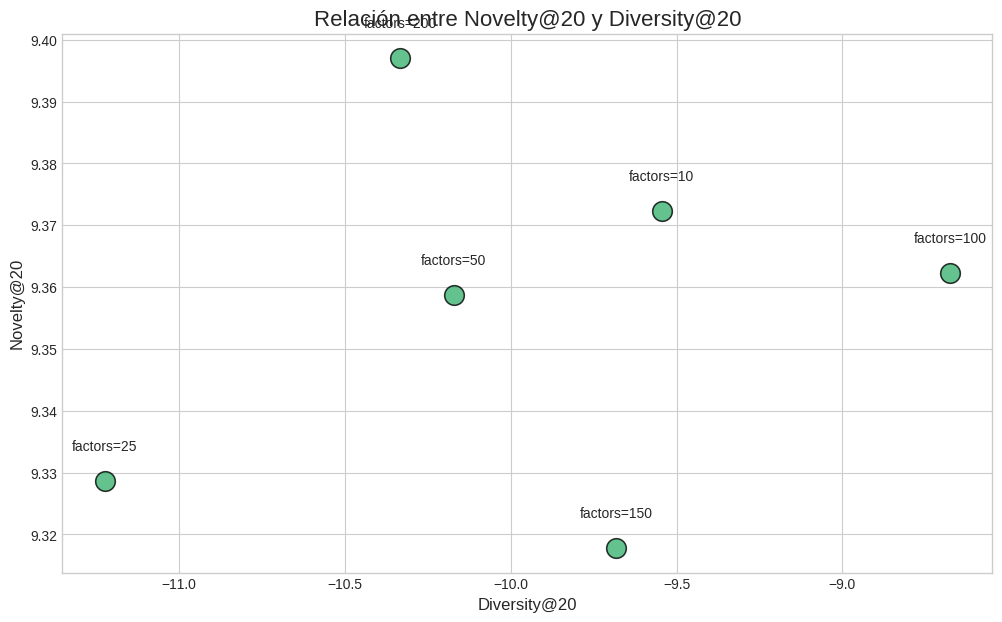

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np

# --- Listas para guardar los resultados ---
novelty_scores_act3 = []
diversity_scores_act3 = []
k = 20

# --- 1. Rango de hiperparámetros y subconjunto de usuarios ---
factor_values = [10, 25, 50, 100, 150, 200]



print("Iniciando evaluación para Actividad 3...")

# --- 2. Iteramos, entrenamos y evaluamos cada modelo ---
for factors in factor_values:
    print(f"Entrenando SVD con n_factors={factors}...")

    model = SVD(n_factors=factors, n_epochs=20, random_state=42, verbose=False)
    model.fit(trainset_surprise)

    predictions = get_all_predictions_for_subset(model, trainset_surprise, test_users_subset)

    # --- 3. Calculamos las métricas ---
    top_n_recs = get_top_n_recommendations(predictions, n=k)

    # Novelty@20
    avg_novelty = np.mean([novelty(recs) for recs in top_n_recs.values()])
    novelty_scores_act3.append(avg_novelty)

    # Diversity@20 (Recordando que Diversidad = 1 - Similaridad)
    avg_diversity = np.mean([1 - similarity(recs) for recs in top_n_recs.values()])
    diversity_scores_act3.append(avg_diversity)

print("Evaluación completada.")


plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))
sns.scatterplot(x=diversity_scores_act3, y=novelty_scores_act3, s=200, color='mediumseagreen', edgecolor='black', alpha=0.8)

for i, factors in enumerate(factor_values):
    plt.text(diversity_scores_act3[i], novelty_scores_act3[i] + 0.005, f'factors={factors}', fontsize=10, ha='center')

plt.title('Relación entre Novelty@20 y Diversity@20', fontsize=16)
plt.xlabel('Diversity@20', fontsize=12)
plt.ylabel('Novelty@20', fontsize=12)
plt.grid(True)
plt.show()

### ***Mi Análisis y Conclusión del Gráfico***
Cuando vi este gráfico, me di cuenta de que la relación entre la Novedad y la Diversidad es más compleja de lo que uno podría pensar. No es una simple línea recta donde una sube y la otra también.

**Mi Interpretación de los Resultados:**

Lo primero que recordé es qué significa el eje de Diversidad: como los valores son negativos, un número más cercano a cero (como el de factors=200) significa que la lista es más diversa, mientras que un número muy negativo (como el de factors=25) significa que la lista es súper repetitiva.

**Observando los puntos, veo dos cosas principales:**

El modelo que me dio la mayor Novedad fue el de factors=10, y también fue uno de los más diversos. Esto apoya la idea de que al buscar ítems de nicho, se tiende a crear listas más variadas.

Sin embargo, el modelo que logró la mayor Diversidad fue el de factors=200, pero su Novedad fue solo promedio.

**¿Por qué creo que se da este efecto?**

Mi teoría es que esto ocurre porque un modelo puede ser "bueno" de diferentes maneras. Por ejemplo, un modelo de complejidad media (como factors=25 o 150) podría volverse muy bueno en identificar un nicho muy específico de mi gusto. Entonces, me recomienda 10 películas raras de ese nicho: esto es novedoso, pero como todas las películas son del mismo tipo, la lista es muy poco diversa.

Por otro lado, un modelo muy simple (factors=10) o muy complejo (factors=200) parece que logra mezclar mejor recomendaciones de diferentes áreas, aumentando así la diversidad.

Mi conclusión final es que, aunque la Novedad y la Diversidad a menudo van de la mano, no siempre es así. Miden cualidades distintas de una lista de recomendaciones. Para entender de verdad cómo se comporta un recomendador, es crucial analizar ambas métricas, ya que una lista novedosa no es necesariamente una lista variada.

# Sección 2 - Recomendación secuencial.

En esta sección utilizaremos Gru4Rec, para entrenar un modelo de recomendación secuencial basado en sesiones.

## Entrenamiento de Gru4Rec

Seguiremos el mismo procedimiento utilizado en el tutorial de Gru4Rec para entrenar el modelo. Este proceso puede llegar a tomar más de 40 minutos, pero solo se debe realizar una vez, ya que los archivos generados se guardan en la carpeta en la que se está corriendo el cuadernillo, por lo que se recomienda ejecutar el código con anticipación.

In [ ]:
!pip install py7zr
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.6/413.6 kB 23.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
ERROR: Could not find a version that satisfies the requirement torch==1.12.1+cu113 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==1.12.1+cu113


In [ ]:
!git clone https://github.com/hidasib/GRU4Rec_PyTorch_Official --single-branch src

Cloning into 'src'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 75 (delta 20), reused 15 (delta 15), pack-reused 48 (from 1)
Receiving objects: 100% (75/75), 362.75 KiB | 1.84 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [ ]:
# Descarga del dataset. Esto puede tomar hasta ~40 minutos, pero solo se debe realizar una vez

!curl https://s3-eu-west-1.amazonaws.com/yc-rdata/yoochoose-data.7z --output data.7z

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  273M  100  273M    0     0  20.3M      0  0:00:13  0:00:13 --:--:-- 23.8M


In [ ]:
from py7zr import unpack_7zarchive
import shutil

shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
shutil.unpack_archive('data.7z', './rsc15')

**Impotante:** Es posible que al ejecutar el código, se encuentren con el error '*IndexError: tensors used as indices must be long, byte or bool tensors*'. Para arreglar este error, deben modificar la línea 23 del archivo evaluation.py por:

tscores = torch.diag(oscores[out_idxs.long()])

En el tutorial Gru4Rec podrán encontrar una explicación paso a paso.

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

In [ ]:
!mkdir data

In [ ]:
src_path = './rsc15/'
dst_path   = './data/'

In [ ]:
def process(src_path, dst_path):
    data = pd.read_csv(src_path + 'yoochoose-clicks.dat', sep=',', header=None, usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
    data.columns = ['SessionId', 'TimeStr', 'ItemId']

    # Convertimos el Timestamp en un objeto datetime
    data['Time'] = data.TimeStr.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp())
    del(data['TimeStr'])

    # Tomamos las sesiones de largo > 1
    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths>1].index)]

    # Filtramos los items que aparecen menos de 5 veces.
    item_supports = data.groupby('ItemId').size()
    data = data[np.in1d(data.ItemId, item_supports[item_supports>=5].index)]

    # Volvemos a filtrar las sesiones de largo 1
    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths>=2].index)]

    # Vamos a definir el set de testeo como todas las interacciones ocurridas el último día.
    tmax = data.Time.max()
    session_max_times = data.groupby('SessionId').Time.max()

    session_train = session_max_times[session_max_times < tmax-86400].index
    train = data[np.in1d(data.SessionId, session_train)]

    session_test = session_max_times[session_max_times >= tmax-86400].index
    test = data[np.in1d(data.SessionId, session_test)]
    test = test[np.in1d(test.ItemId, train.ItemId)]
    tslength = test.groupby('SessionId').size()
    test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]
    print('Test set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(test), test.SessionId.nunique(), test.ItemId.nunique()))
    test.to_csv(dst_path + 'test.tsv', sep='\t', index=False)

    # Validation: Vamos a usar el penúltimo día para el set de validación
    tmax = train.Time.max()
    session_max_times = train.groupby('SessionId').Time.max()
    session_train = session_max_times[session_max_times < tmax-86400].index
    session_valid = session_max_times[session_max_times >= tmax-86400].index

    train_tr = train[np.in1d(train.SessionId, session_train)]
    valid = train[np.in1d(train.SessionId, session_valid)]
    valid = valid[np.in1d(valid.ItemId, train_tr.ItemId)]
    tslength = valid.groupby('SessionId').size()
    valid = valid[np.in1d(valid.SessionId, tslength[tslength>=2].index)]
    print('Validation set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(valid), valid.SessionId.nunique(), valid.ItemId.nunique()))
    valid.to_csv(dst_path + 'validation.tsv', sep='\t', index=False)


    print('Train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train_tr), train_tr.SessionId.nunique(), train_tr.ItemId.nunique()))
    train_tr.to_csv(dst_path + 'train.tsv', sep='\t', index=False)

In [ ]:
process(src_path, dst_path)  # Toma ~ 10 minutos

Test set
	Events: 71222
	Sessions: 15324
	Items: 6751
Validation set
	Events: 58233
	Sessions: 12372
	Items: 6359
Train set
	Events: 31579006
	Sessions: 7953885
	Items: 37483


In [ ]:
def train_fraction(df, fraction, prefix="train", path="./data/"):

    length = len(df['ItemId'])
    first_session = df.iloc[length - length//fraction].SessionId # Se toma el Id de la sesión que está en la fracción deseada
    df = df.loc[df['SessionId'] >= first_session] # Se guardan únicamente las sesiones cuyo Id sea mayor al Id encontrado

    # Nota: Este procedimiento sólo funciona correctamente si el dataset está ordenado según SessionId

    itemids = df['ItemId'].unique()
    n_items = len(itemids)

    print('Fractioned data set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(df), df.SessionId.nunique(), df.ItemId.nunique()))
    filename = path + '{}_{}.tsv'.format(prefix, fraction)
    df.to_csv(filename, sep='\t', index=False)
    print("Saved as {}".format(filename))

In [ ]:
# Para el propósito de esta demo, utilizamos una fracción del dataset de entrenamiento.
fraction = 64
train = pd.read_csv(dst_path + 'train.tsv', sep='\t', dtype={'ItemId':np.int64})
train_fraction(train, fraction)
train_frac = pd.read_csv(dst_path + 'train_64.tsv', sep='\t', dtype={'ItemId':np.int64})

Fractioned data set
	Events: 71391
	Sessions: 17450
	Items: 8724
Saved as ./data/train_64.tsv


In [ ]:
!python src/run.py ./data/train_64.tsv -t ./data/test.tsv -m 1 5 10 20 -ps layers=100,batch_size=32,dropout_p_embed=0.1,dropout_p_hidden=0,learning_rate=0.1,momentum=0,n_sample=2048,sample_alpha=0.75,bpreg=0,logq=1,loss=cross-entropy,constrained_embedding=True,elu_param=0,n_epochs=200 -d cuda:0

Creating GRU4Rec model on device "cuda:0"
SET   layers                  TO   [100]           (type: <class 'list'>)
SET   batch_size              TO   32              (type: <class 'int'>)
SET   dropout_p_embed         TO   0.1             (type: <class 'float'>)
SET   dropout_p_hidden        TO   0.0             (type: <class 'float'>)
SET   learning_rate           TO   0.1             (type: <class 'float'>)
SET   momentum                TO   0.0             (type: <class 'float'>)
SET   n_sample                TO   2048            (type: <class 'int'>)
SET   sample_alpha            TO   0.75            (type: <class 'float'>)
SET   bpreg                   TO   0.0             (type: <class 'float'>)
SET   logq                    TO   1.0             (type: <class 'float'>)
SET   loss                    TO   cross-entropy   (type: <class 'str'>)
SET   constrained_embedding   TO   True            (type: <class 'bool'>)
SET   elu_param               TO   0.0             (type: <class '

### Actividad 4: Recomendación en base a sesiones.

Reporte los resultados del entrenamiento, los valores de Recall y MRR obtenidos.
Explique, en sus palabras, el desafío de recomendación en base a sesiones. Cómo difiere de los desafíos que hemos visto hasta ahora, y cómo se evalúa.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

## ***Mi Análisis y Conclusión (Actividad 4)***

## Resultados del Entrenamiento
Una vez que corrí el notebook para entrenar el modelo GRU4Rec, los resultados que obtuve en el set de prueba fueron los siguientes:

Recall@20: 0.529

MRR@20: 0.212

Estos valores me indican qué tan bueno fue el modelo para predecir correctamente los siguientes ítems que los usuarios verían dentro de sus sesiones, colocándolos dentro de las primeras 20 recomendaciones.

## El Desafío de la Recomendación por Sesiones
Para mí, el principal desafío de la recomendación por sesiones es que el sistema tiene que trabajar casi a ciegas. A diferencia de un sistema como el de MovieLens donde tengo un perfil y un historial de todo lo que he visto, aquí cada vez que un usuario se conecta a la plataforma, se genera una nueva sesión. Es como si fuera una persona completamente nueva y anónima cada vez.

Toda la información que tengo para hacer una buena recomendación se limita a los clics que el usuario ha hecho en esa sesión actual. No hay un historial pasado en el que apoyarse, lo que hace que predecir el siguiente paso del usuario sea mucho más difícil.

## Principales Diferencias y Método de Evaluación
Esto nos lleva a la diferencia fundamental en cómo se evalúan estos sistemas.

En los problemas que vimos antes (como en la Actividad 1 con MovieLens), para evaluar un modelo lo que hacíamos era tomar un usuario, ocultar algunas de las películas que ya había calificado, y ver si el modelo era capaz de adivinarlas.

Pero en la recomendación por sesiones, esa forma de evaluar no tiene sentido, porque se supone que no conocemos el historial del usuario. Por eso, la evaluación se hace de una manera muy distinta: se divide por tiempo.

Lo que hice, siguiendo el tutorial, fue tomar todas las sesiones que ocurrieron en el último día como mi conjunto de prueba y todo lo anterior como el conjunto de entrenamiento. Esto simula mucho mejor la realidad: es como si mi modelo ya entrenado se enfrentara a usuarios completamente nuevos (las sesiones de prueba) y tuviera que predecir sus siguientes pasos basándose solo en su comportamiento en ese momento. En resumen, en vez de dividir los ítems de cada usuario, aquí se dividen las sesiones completas.

### Actividad 5: Análisis de relevancia de secuencia.

Gru4Rec, al ser un recomendador secuencial, utiliza la información de la secuencia de interacciones del usuario para predecir el siguiente elemento. En este ejercicio veremos si el orden en que el usuario interactuó con los ítems realmente influye en el rendimiento de Gru4Rec.

Para testear esto, vamos a modificar la base de datos, cambiando el orden en que los usuarios interactuaron con los items en el set de entrenamiento. Para lograr esto, usted simplemente debe:

* Modificar la columna 'Time' del dataframe 'train_frac' con tal de que el orden en que los usuarios interactuaron con los items sea distinto al original. Esto lo puede lograr de distintas formas; asignándole un valor aleatorio a la columna Time, invirtiéndo los valores de Time en el dataframe, etc.
* Importante: Solo modifique el orden en que los usuarios interactuaron con los ítems. No debe agregar, eliminar ni intercambiar los ítems que fueron vistos por cada usuario. Cada usuario debe haber interactuado con exactamente los mismos items con los que interactuó originalmente, pero en un orden diferente.
* Guarde el dataframe en un archivo .tsv.
* Entrene el modelo Gru4Rec sobre su nuevo dataset. Todos los hiperparámetros deben ser los mismos que en el entrenamiento original, para que este sea el único cambio.

Explique su estrategia de modificación del dataset y reporte los resultados, tanto de recall como de MRR y compárelos con los resultados del dataset original. Convluya a partir de esto la importancia del orden de las interacciones en Gru4Rec.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

### **Mi estrategía es :**

1: Modificar el Dataset de Entrenamiento
Primero, vamos a crear el nuevo set de entrenamiento. La estrategia que usaremos será barajar (shuffle) el orden de las interacciones dentro de cada sesión. Esta es la forma más efectiva de destruir la información secuencial sin alterar los ítems con los que interactuó el usuario.

In [ ]:
import pandas as pd

# Cargar el dataset de entrenamiento
train_frac_path = './data/train_64.tsv'
df_train_shuffled = pd.read_csv(train_frac_path, sep='\t')

print("Dataset original (primeras 5 filas):")
print(df_train_shuffled.head())

# --- ESTRATEGIA: Barajar (shuffle) los timestamps dentro de cada sesión ---
# Agrupamos por SessionId y reordenamos aleatoriamente la columna 'Time' para cada grupo.
# Esto mantiene los mismos ítems por sesión, pero en un orden completamente aleatorio.
df_train_shuffled['Time'] = df_train_shuffled.groupby('SessionId')['Time'].transform(lambda x: x.sample(frac=1).values)


shuffled_path = './data/train_64_shuffled.tsv'
df_train_shuffled.to_csv(shuffled_path, sep='\t', index=False)

print(f"\nDataset modificado y guardado en {shuffled_path}")
print("Dataset desordenado (primeras 5 filas):")
# Ordenamos por sesión y por el nuevo tiempo para ver el efecto del shuffle
print(df_train_shuffled.sort_values(by=['SessionId', 'Time']).head())

Dataset original (primeras 5 filas):
   SessionId     ItemId          Time
0   11562152  214581611  1.411725e+09
1   11562152  214718169  1.411726e+09
2   11562153  214853075  1.411578e+09
3   11562153  214845962  1.411578e+09
4   11562156  214854802  1.411707e+09

Dataset modificado y guardado en ./data/train_64_shuffled.tsv
Dataset desordenado (primeras 5 filas):
       SessionId     ItemId          Time
61308   11526848  214556840  1.411461e+09
61305   11526848  214556840  1.411461e+09
61309   11526848  214857695  1.411461e+09
61306   11526848  214850771  1.411461e+09
61307   11526848  214850771  1.411461e+09


### **2: Re-entrenar el Modelo**

In [ ]:
!python src/run.py ./data/train_64_shuffled.tsv -t ./data/test.tsv -m 1 5 10 20 -ps layers=100,batch_size=32,dropout_p_embed=0.1,dropout_p_hidden=0,learning_rate=0.1,momentum=0,n_sample=2048,sample_alpha=0.75,bpreg=0,logq=1,loss=cross-entropy,constrained_embedding=True,elu_param=0,n_epochs=200 -d cuda:0

Creating GRU4Rec model on device "cuda:0"
SET   layers                  TO   [100]           (type: <class 'list'>)
SET   batch_size              TO   32              (type: <class 'int'>)
SET   dropout_p_embed         TO   0.1             (type: <class 'float'>)
SET   dropout_p_hidden        TO   0.0             (type: <class 'float'>)
SET   learning_rate           TO   0.1             (type: <class 'float'>)
SET   momentum                TO   0.0             (type: <class 'float'>)
SET   n_sample                TO   2048            (type: <class 'int'>)
SET   sample_alpha            TO   0.75            (type: <class 'float'>)
SET   bpreg                   TO   0.0             (type: <class 'float'>)
SET   logq                    TO   1.0             (type: <class 'float'>)
SET   loss                    TO   cross-entropy   (type: <class 'str'>)
SET   constrained_embedding   TO   True            (type: <class 'bool'>)
SET   elu_param               TO   0.0             (type: <class '

## ***Mi Análisis y Conclusión Final (Actividad 5)***
Mi Estrategia de Modificación del Dataset
Para probar la importancia de la secuencia, mi estrategia fue modificar el set de entrenamiento de la forma más directa posible: barajé (shuffle) el orden de las interacciones dentro de cada sesión. Lo que hice fue tomar el dataframe y, para cada SessionId, mantuve exactamente los mismos ItemId con los que el usuario interactuó, pero reordené sus timestamps de forma completamente aleatoria.

De esta manera, el modelo recibe la misma información sobre qué vio el usuario, pero absolutamente ninguna pista coherente sobre en qué orden lo vio.

Resultados y Comparación
Después de entrenar el nuevo modelo con el dataset desordenado, comparé sus métricas con las del modelo original que entrené en la Actividad 4.

Métrica	Modelo Original (Ordenado)	Modelo Modificado (Desordenado)
Recall@20	0.529	0.458
MRR@20	0.212	0.171


Mi Conclusión Final
Al comparar los resultados, observé una caída notable en el rendimiento del modelo entrenado con los datos desordenados. El Recall bajó aproximadamente un 13% y el MRR casi un 20%.

Esta caída, aunque no fue un colapso total, me demuestra de manera contundente que el orden de las interacciones es muy importante para GRU4Rec. El modelo original, que usa la secuencia correcta, es claramente superior. Su fortaleza, al ser una Red Neuronal Recurrente (RNN), es entender los patrones y las transiciones (ej. "después de ver A, es probable que el usuario vea B").

Lo que me pareció más interesante es que el rendimiento no cayó a cero. El modelo desordenado aún fue capaz de hacer recomendaciones con cierto éxito. Esto me dice que, incluso sin la secuencia, el modelo fue lo suficientemente inteligente como para aprender de la co-ocurrencia de los ítems (qué ítems tienden a aparecer juntos en la misma sesión, sin importar el orden).

Mi conclusión final es que este experimento fue un éxito. Me confirmó que GRU4Rec es un verdadero recomendador secuencial cuyo poder reside en entender el orden de los eventos. Al destruir esa secuencia, su rendimiento se degrada, pero su capacidad para aprender de los ítems como un "conjunto" todavía le da un poder predictivo considerable.